Estimación Lista
{'turnos': [{'horaDesde': '08:00', 'horaHasta': '11:00', 'cantidad': 5}, {'horaDesde': '08:00', 'horaHasta': '12:00', 'cantidad': 1}, {'horaDesde': '08:30', 'horaHasta': '11:30', 'cantidad': 2}, {'horaDesde': '09:00', 'horaHasta': '12:00', 'cantidad': 4}, {'horaDesde': '09:00', 'horaHasta': '13:00', 'cantidad': 0}, {'horaDesde': '10:00', 'horaHasta': '12:00', 'cantidad': 2}, {'horaDesde': '10:00', 'horaHasta': '13:00', 'cantidad': 2}, {'horaDesde': '10:00', 'horaHasta': '14:00', 'cantidad': 0}, {'horaDesde': '11:00', 'horaHasta': '13:00', 'cantidad': 0}, {'horaDesde': '11:00', 'horaHasta': '14:00', 'cantidad': 15}, {'horaDesde': '11:00', 'horaHasta': '15:00', 'cantidad': 32}, {'horaDesde': '12:00', 'horaHasta': '14:00', 'cantidad': 73}, {'horaDesde': '12:00', 'horaHasta': '15:00', 'cantidad': 33}, {'horaDesde': '12:00', 'horaHasta': '16:00', 'cantidad': 7}, {'horaDesde': '13:00', 'horaHasta': '16:00', 'cantidad': 29}, {'horaDesde': '13:00', 'horaHasta': '17:00', 'canti

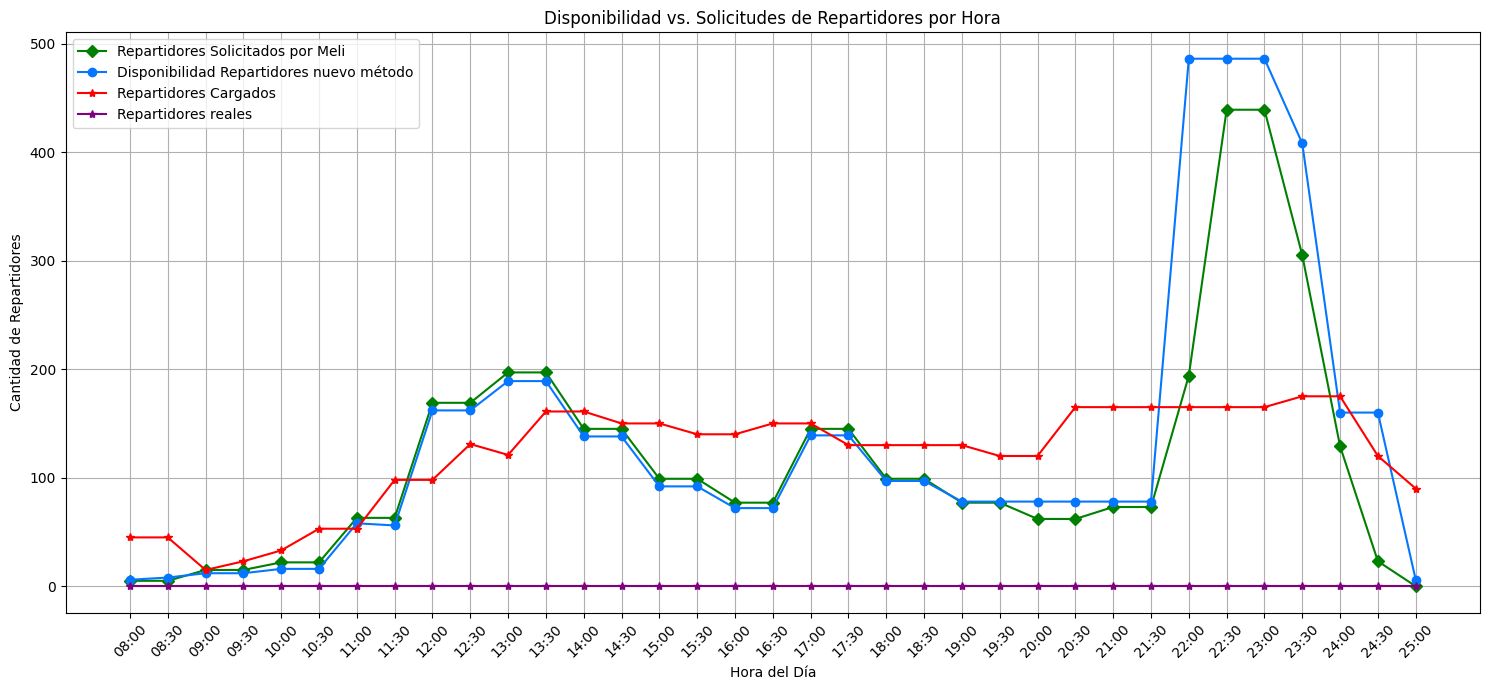

Total Reservas nuevoestimador: 844
[{'horaDesde': '08:00', 'horaHasta': '11:00', 'cantidad': 5}, {'horaDesde': '08:00', 'horaHasta': '12:00', 'cantidad': 1}, {'horaDesde': '08:30', 'horaHasta': '11:30', 'cantidad': 2}, {'horaDesde': '09:00', 'horaHasta': '12:00', 'cantidad': 4}, {'horaDesde': '09:00', 'horaHasta': '13:00', 'cantidad': 0}, {'horaDesde': '10:00', 'horaHasta': '12:00', 'cantidad': 2}, {'horaDesde': '10:00', 'horaHasta': '13:00', 'cantidad': 2}, {'horaDesde': '10:00', 'horaHasta': '14:00', 'cantidad': 0}, {'horaDesde': '11:00', 'horaHasta': '13:00', 'cantidad': 0}, {'horaDesde': '11:00', 'horaHasta': '14:00', 'cantidad': 15}, {'horaDesde': '11:00', 'horaHasta': '15:00', 'cantidad': 32}, {'horaDesde': '12:00', 'horaHasta': '14:00', 'cantidad': 73}, {'horaDesde': '12:00', 'horaHasta': '15:00', 'cantidad': 33}, {'horaDesde': '12:00', 'horaHasta': '16:00', 'cantidad': 7}, {'horaDesde': '13:00', 'horaHasta': '16:00', 'cantidad': 29}, {'horaDesde': '13:00', 'horaHasta': '17:00',

In [11]:
import pandas as pd
import requests
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from QueryReservasxHora import generarQuery
import math


def Estimar2(fecha, incremento_pct=0, incremento_pct_meli=50, inicio_incremento_meli=29):
    class Reserva:
        def __init__(self, horaDesde, horaHasta):
            self.horaDesde = horaDesde
            self.horaHasta = horaHasta

    horarios = np.arange(8, 25.5, 0.5)
    # horarioAux = np.arange(10, 25 - duracion, 1)
    # horariosReservas = [(i, i + duracion) for i in horarioAux]
    
    horariosReservas = [
        (8,11),
        (8,12),
        (8.5,11.5),
        (9,12),
        (9,13),
        (10,12),
        (10,13),
        (10,14),
        (11,13),
        (11,14),
        (11,15),
        (12,14),
        (12,15),
        (12,16),
        (13,16),
        (13,17),
        (13.5,16),
        (14,16),
        (14,17),
        (14,18),
        (15,17),
        (15,18),
        (15,19),
        (16,18),
        (16,19),
        (16,20),
        (17,19),
        (17,20),
        (17,21),
        (18,20),
        (18,21),
        (18,22),
        (18.5,22.5),
        (19,21),
        (19,22),
        (19,23),
        (19,23.5),
        (20,0),
        (20,22),
        (20,23),
        (21,0),
        (21,1),
        (21,23),
        (22,24),
        (22,25),
        (22,25.5)
        ]

    def obtener_valores_por_fecha(fecha):
        url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTqP8Cc8coM8EqPpAHDiRtyX2sxd1gokCUCbR8erhVrs7O9hXXbW0oruGaZIDtXYvLAztNoLG645L0I/pub?output=csv"
        response = requests.get(url)
        assert response.status_code == 200, 'Error al descargar los datos'
        df = pd.read_csv(url)
        
        columna_fecha = None
        for col in df.columns:
            if df[col].iloc[0] == fecha:
                columna_fecha = col
                break
        
        if columna_fecha is None:
            return f"No se encontró la fecha {fecha}"
        
        valoresMeli = [int(valor) for valor in df[columna_fecha].dropna().tolist() if valor.isdigit()]

        valoresMeliIncrementados = [0]*len(valoresMeli)


        # Aplicar incremento a los valores de Meli desde el índice especificado
        for i in range(inicio_incremento_meli, len(valoresMeliIncrementados)):
            valoresMeliIncrementados[i] = math.ceil(valoresMeli[i] + valoresMeli[i] * incremento_pct_meli / 100)

        for i in range(0, inicio_incremento_meli):
            valoresMeliIncrementados[i] = valoresMeli[i]      


        return valoresMeli, valoresMeliIncrementados

    reservasMeli, valoresMeliIncrementados = obtener_valores_por_fecha(fecha)

    def calcular_disponibilidad(configuracion):
        reservas = [Reserva(horariosReservas[i][0], horariosReservas[i][1]) for i, cantidad in enumerate(configuracion) for _ in range(round(cantidad))]
        disponibilidad = [sum(1 for reserva in reservas if reserva.horaDesde <= hora and reserva.horaHasta > hora) for hora in horarios]
        return disponibilidad

    def objetivo(config):
        disponibilidad = calcular_disponibilidad(config)
        if len(valoresMeliIncrementados) != len(disponibilidad):
            print (valoresMeliIncrementados)
            print (len(valoresMeliIncrementados))
            print (disponibilidad)
            print(len(disponibilidad))
            raise ValueError("Error: diferentes largos entre listas de disponibilidad meli-rapiboy")
        # return sum((rm - rd)**2 for rm, rd in zip(valoresMeliIncrementados, disponibilidad))##función costo. Acá hay que meter para que no haya mucho repartidor al dope.
        return sum((rm - rd)**2 for rm, rd in zip(valoresMeliIncrementados, disponibilidad)) + sum(config)

    def convertir_horas(value):
        
        #Convierto formato de horas de numero a string fixeando horarios 24 a horarios 00
        hours = int(value) if int(value) < 24 else int(value) - 24  # Parte entera para las hora
        minutes = int(((value - hours) * 60 if hours > 1 
                       else ( (value - 25) if hours == 1 
                       else (value - 24)) * 60))  # Parte decimal convertida a minutos
        
        # Formatear como HH:MM
        time_string = f"{hours:02d}:{minutes:02d}"
        
        return time_string




    valores_iniciales = [valoresMeliIncrementados[0]] * len(horariosReservas)
    bounds = [(0, None) for _ in range(len(valores_iniciales))] #Establezco limites de valores para cada turno. Inicio con todos positivos. Nunca reservas negativasd.
    bounds[0] = (valoresMeliIncrementados[0], None) #Reemplazo el límite del primer horario dado que tengo que arrancar siempre con lo que pide meli, no puedo arrancar con 0 repas.
    # bounds = [(valoresMeliIncrementados[0], None) for _ in range(len(valores_iniciales))]
    resultado_optimizacion = minimize(objetivo, valores_iniciales, method='Powell', bounds=bounds)
    configuracionOptima = [int(x) for x in resultado_optimizacion.x] #convierto valores en enteros.

    if incremento_pct != 0:
        # Aplicar el incremento porcentual y redondear hacia arriba
        configuracionIncrementada = [math.ceil(x + x * incremento_pct / 100) for x in configuracionOptima]
    
    else:
        configuracionIncrementada = configuracionOptima

    Resultados = [{'horaDesde': convertir_horas(horariosReservas[i][0]), 'horaHasta': convertir_horas(horariosReservas[i][1]), 'cantidad': configuracionIncrementada[i]} for i in range(len(horariosReservas))]

    # Calcular la disponibilidad final usando la configuración incrementada
    disponibilidadFinal = calcular_disponibilidad(configuracionIncrementada)

    final = {
        "turnos": Resultados,
        "disponibilidadFinal": disponibilidadFinal,
        "necesidadesMeli": reservasMeli,
        "totalReservas" : sum(configuracionIncrementada)
    }

    return final

def RepasReales(fecha):

    server = '190.210.150.90,1433'
    database = 'rapiboyv7'
    username = 'gastonMichelotti'
    password = 'e4c9b81800490aab2c7ece08018853f23ac75e08ecb7725a6d6cb496539b3fe1'
    driver= 'ODBC Driver 17 for SQL Server'
    port= '1433'

    # Formulate the connection string for SQLAlchemy with pyodbc
    conn = f"mssql+pyodbc://{username}:{password}@{server}:{port}/{database}?driver={driver}"

    # Create an SQLAlchemy engine
    engine = create_engine(conn)

    query = generarQuery(fecha)

    result = pd.read_sql(query,engine)

    return result

def graficar_resultados(resultado, reales, resultadooriginal = None):
    horarios = [f"{int(hora):02d}:{int((hora - int(hora)) * 60):02d}" for hora in np.arange(8, 25.5, 0.5)]
    disponibilidadFinal = resultado["disponibilidadFinal"]

    if resultadooriginal != None:
        disponibilidadOriginal = resultadooriginal["disponibilidadFinal"]
    necesidadesMeli = resultado["necesidadesMeli"]
    disponibilidadCargada = reales["TotalReservas"]
    disponibilidadReal = reales["ReservasConLlegada"]


    plt.figure(figsize=(15, 7))
    plt.plot(horarios, necesidadesMeli[:len(horarios)], label='Repartidores Solicitados por Meli', marker='D', color = 'green')
    plt.plot(horarios, disponibilidadFinal, label='Disponibilidad Repartidores nuevo método', marker='o', color = '#0576ff')
    # plt.plot(horarios, disponibilidadOriginal, label='Disponibilidad Repartidores VIeja', marker='p', color = 'black')
    plt.plot(horarios, disponibilidadCargada, label='Repartidores Cargados ', marker='*', color = 'red')
    plt.plot(horarios, disponibilidadReal, label='Repartidores reales', marker='*', color = 'purple')
    plt.title('Disponibilidad vs. Solicitudes de Repartidores por Hora')
    plt.xlabel('Hora del Día')
    plt.ylabel('Cantidad de Repartidores')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    


def revisionMeli(fecha, aumento = 0, aumentoDemanda = 0, aumentoDesde = 0, verbose = True):

    estimacion = Estimar2(fecha, aumento, aumentoDemanda,aumentoDesde)
    # estimacionVieja = Estimar3(fecha,4,  aumento, aumentoDemanda,aumentoDesde)
    if verbose == True:
        print("Estimación Lista")
        print(estimacion)

    # estimacion_original = Estimar2(fecha, duracion, 0, 0, 0)
    # if verbose == True:
    #     print("Estimación no fixeada Lista")

    reales = RepasReales(fecha)
    if verbose == True:
        print("Disponibilidad Real Lista")

    graficar_resultados(estimacion,reales)
    print( "Total Reservas nuevoestimador:" ,estimacion["totalReservas"])
    # print("Total Reservas vijeas:", estimacionVieja["totalReservas"])
    print(estimacion["turnos"])
    print(estimacion["disponibilidadFinal"])
    print("Repas Cargados Reales:", reales["TotalReservas"])

    return estimacion

revision = revisionMeli('23/08', 0, 50, 29)

In [ ]:
def convertir_horas(value):
        
        #Convierto formato de horas de numero a string fixeando horarios 24 a horarios 00
        hours = int(value) if int(value) < 24 else int(value) - 24  # Parte entera para las hora
        minutes = int(((value - hours) * 60 if hours > 1 
                       else ( (value - 25) if hours == 1 
                       else (value - 24)) * 60))  # Parte decimal convertida a minutos
        
        # Formatear como HH:MM
        time_string = f"{hours:02d}:{minutes:02d}"
        
        return time_string

convertir_horas(25)



'01:00'